# Create Matrix for Features

In [1]:
import itertools
import Bio
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from itertools import combinations
name_450Tryptorubinlikes="Fasta/sirinsp450.fasta"
name_450nonTryptorubinlikes="Fasta/all p450.fasta"
foldernameoutput="Output/Tryptorubinlike_peptide"

#set to legth of sequence motive you want to test
length=4
#creates a list of all sequence motifs to look for
combinations=list(itertools.combinations_with_replacement(["a","b","p","r","s","t","n"], length))
permutations=list()

for a in combinations:
    permutations=permutations+ list(itertools.permutations(a,length))
permutations=([ "".join(a) for a in list(dict.fromkeys(permutations))])

# remove all combinations not in sequences
def easysequence (sequence):
    #creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr=str(sequence)
    seqlist=list(seqstr)
    a=0
    easylist=[]
    for i in seqlist:
        if i == 'E' or i== 'D':
            
            easylist=easylist+['a']
        if i == 'K' or i=='R' or i=='H':
            
            easylist=easylist+['b']
        if i == 'S' or i=='T' or i=='N' or i=='Q':
            
            easylist=easylist+['p']
        if i == 'F' or i=='Y' or i=='W':
            
            easylist=easylist+['r']
        if i == 'C':
            easylist=easylist+['s']
            
        if i == 'P':
            easylist=easylist+['t']
            
        if i == 'G' or i=='A' or i=='V' or i=='L' or i=='I' or i=='M':
            easylist=easylist+['n']         
    seperator=''
    easysequence=seperator.join(easylist)
    return easysequence

for p in permutations:
    counter=0
    counter2=0
    for seq_record in SeqIO.parse(name_450Tryptorubinlikes, "fasta"):
        easyseq=easysequence(seq_record.seq)
        if easyseq.count(p)>0:
            counter=counter+1
        counter2=counter2+1
    if counter<(round(counter2)/2):
        permutations.remove(p)
print ("Number of remaining features:",len(permutations))

#final "permutations" should be a list of all sequence motifs to look for
try:
    os.makedirs(foldernameoutput)
except OSError:
    print ("Creation of the directory %s failed" % foldernameoutput)
else:
    print ("Successfully created the directory %s" % foldernameoutput)
filename_permutations=foldernameoutput+"/permutations.txt"
with open(filename_permutations, 'w') as f:
    for s in permutations:
        f.write(str(s) + '\n')

KeyboardInterrupt: 

# Create Feature Matrix

In [3]:


#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 26 08:26:52 2022

@author: friederike
"""

import Bio
import pandas as pd
from Bio import SeqIO
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
import re
import numpy as np
fastas_aligned_before=False

include_charge_features=True
#fill in filenames here!
foldernameoutput="Output/tryptorubinlike_peptide"
name_450tryptorubinlike_peptides="Fasta/sirinsp450.fasta" #insert either name of fasta or alignment in fasta format (alignment must include "Reference_P450")
name_450nontryptorubinlike_peptides="Fasta/allP450s_antismash_db.faa" #insert either name of fasta or alignment in fasta format(alignment must include "Reference_P450")
filename_permutations=foldernameoutput+"/permutations.txt"
alignmentfa=("MSAVALPRVSGGHDEHGHLEEFRTDPIGLMQRVRDECGDVGTFQLAGKQVVLLSGSHANEFFFRAGDDDLDQAKAYPFMTPIFGEGVVFDASPERRKEMLHNAALRGEQMKGHAATIEDQVRRMIADWGEAGEIDLLDFFAELTIYTSSACLIGKKFRDQLDGRFAKLYHELERGTDPLAYVDPYLPIESLRRRDEARNGLVALVADIMNGRIANPPTDKSDRDMLDVLIAVKAETGTPRFSADEITGMFISMMFAGHHTSSGTASWTLIELMRHRDAYAAVIDELDELYGDGRSVSFHLRQIPQLENVLKETLRLHPPLIILMRVAKGEFEVQGHRIHEGDLVAASPAISNRIPEDFPDPHDFVPARYEQPRQEDLLNRWTWIPFGAGRHRCVGAAFAIMQIKAIFSVLLREYEFEMAQPPESYRNDHSKMVVQLAQPACVRYRRRTGV")
   
#alignmentfa=(SeqRecord(Seq("MSAVALPRVSGGHDEHGHLEEFRTDPIGLMQRVRDECGDVGTFQLAGKQVVLLSGSHANEFFFRAGDDDLDQAKAYPFMTPIFGEGVVFDASPERRKEMLHNAALRGEQMKGHAATIEDQVRRMIADWGEAGEIDLLDFFAELTIYTSSACLIGKKFRDQLDGRFAKLYHELERGTDPLAYVDPYLPIESLRRRDEARNGLVALVADIMNGRIANPPTDKSDRDMLDVLIAVKAETGTPRFSADEITGMFISMMFAGHHTSSGTASWTLIELMRHRDAYAAVIDELDELYGDGRSVSFHLRQIPQLENVLKETLRLHPPLIILMRVAKGEFEVQGHRIHEGDLVAASPAISNRIPEDFPDPHDFVPARYEQPRQEDLLNRWTWIPFGAGRHRCVGAAFAIMQIKAIFSVLLREYEFEMAQPPESYRNDHSKMVVQLAQPACVRYRRRTGV"),id="Reference_P450"))
path_complete_feature_matrix=foldernameoutput+"/path_complete_feature_matrix.csv"
#S#14703] cytochrome P450 51 Cyp51 ([P#10800] [CYP51] cytochrome P450, family 51 )  from https://cyped.biocatnet.de/sequence/14703

start=0
end=400
splitting_list=[["begin",start,92],["sbr1",93,192],["sbr2",193,275],["core",276,395],["end",396,end],["fes1",54,115],["fes2",302,401]]
fragments=["begin","sbr1","sbr2","core","end","fes1","fes2"]
with open(filename_permutations, 'r') as file:
    permutations = [line.rstrip('\n') for line in file]
def find_between( string, first, last ):
    try:
        start = string.index( first ) + len( first )
        end = string.index( last, start )
        return string[start:end]
    except ValueError:
        return ""
def calculate_charge(sequence):
    AACharge = {"C":-.045,"D":-.999,  "E":-.998,"H":.091,"K":1,"R":1,"Y":-.001}
    charge = -0.002
    seqstr=str(sequence)
    seqlist=list(seqstr)
    for aa in seqlist:
        if aa in AACharge:
            charge += AACharge[aa]
    return charge
def easysequence (sequence):
    #creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr=str(sequence)
    seqlist=list(seqstr)
    easylist=[]
    for i in seqlist:
        if i == 'E' or i== 'D':           
            easylist=easylist+['a']
        if i == 'K' or i=='R' or i=='H':      
            easylist=easylist+['b']
        if i == 'S' or i=='T' or i=='N' or i=='Q':
            easylist=easylist+['p']
        if i == 'F' or i=='Y' or i=='W':
            easylist=easylist+['r']
        if i == 'C':
            easylist=easylist+['s']
        if i == 'P':
            easylist=easylist+['t']
        if i == 'G' or i=='A' or i=='V' or i=='L' or i=='I' or i=='M':
            easylist=easylist+['n']
            
    seperator=''
    easysequence=seperator.join(easylist)
    return easysequence
def indexing_reference(record):
    list_reference=list(str(record.seq))

    index_aa=0
    index_mapping=[]
    for index,AA in enumerate(list_reference):
        if AA !="-":
            index_aa+=1
            index_mapping.append([index_aa,index])

    return (index_mapping)
def convert_splitting_list(splitting_list,index_reference):
    converted_splitting_list=[]
    for fragment in splitting_list:
        converted_splitting_list.append([fragment[0],index_reference[fragment[1]][1],index_reference[fragment[2]-1][1]])
    return converted_splitting_list
def split_alignment(alignment,fragment):
    start=fragment[1]
    end=fragment[2]
    if fastas_aligned_before==False:
        alignment=[alignment]
    seqRecord_list_per_fragment=np.array([["",""]])
    if fragment[0]=="begin":
        start=1
    if fragment[0]!="end":
        for record in alignment:
            subsequence=str(record.seq)[start-1:end]
     
            seqRecord_list_per_fragment=np.append(seqRecord_list_per_fragment,[[record.id,subsequence]],axis=0)
    else:
        for record in alignment:
            subsequence=str(record.seq)[start-1:]
            seqRecord_list_per_fragment=np.append(seqRecord_list_per_fragment,[[record.id,subsequence]],axis=0)
    seqRecord_list_per_fragment=np.delete(seqRecord_list_per_fragment, 0, axis=0)
    return seqRecord_list_per_fragment
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z       
def fragment_alignment(alignment,splitting_list):

    fragment_matrix=pd.DataFrame()
    if fastas_aligned_before==False:
     
        seqa=alignment[0]
        seqb=alignment[1]
        index_reference=indexing_reference(SeqRecord(Seq(seqa),id=seqa))

        converted_splitting_list=convert_splitting_list(splitting_list,index_reference)
        for fragment in converted_splitting_list:
                name_fragment=fragment[0]
                seqRecord_list_per_fragment=split_alignment(SeqRecord(Seq(seqb),id=seqb),fragment)

                fragment_matrix[name_fragment]=seqRecord_list_per_fragment[:,1]
                fragment_matrix.set_index(pd.Index(seqRecord_list_per_fragment[:,0]))
    else:
        for record in alignment:     
            print (record)
            if record.id=="Reference_P450":
                print (record.seq)
                index_reference=indexing_reference(record)
                print(index_reference)
                converted_splitting_list=convert_splitting_list(splitting_list,index_reference)
                for fragment in converted_splitting_list:
                    name_fragment=fragment[0]
                    seqRecord_list_per_fragment=split_alignment(alignment,fragment)
                    fragment_matrix[name_fragment]=seqRecord_list_per_fragment[1]
                    fragment_matrix.set_index(pd.Index(seqRecord_list_per_fragment[0]))
    return fragment_matrix
def featurize(fragment_matrix, permutations, fragments, include_charge_features):
    feature_matrix=pd.DataFrame()
    for index, row in fragment_matrix.iterrows(): 
        new_row={}
        for fragment in fragments:
            sequence_fragment=row[fragment]
            easysequence_fragment=easysequence(sequence_fragment)
            for motif in permutations:
                name_column=motif+fragment
                new_row =merge_two_dicts(new_row,{name_column:easysequence_fragment.count(motif)})
            if include_charge_features==True:
                acidic=fragment+"acidic"
                new_row =merge_two_dicts(new_row,{acidic:(easysequence_fragment.count("a")/len(easysequence_fragment)+1)})
                acidic_absolute=fragment+"acidic absolute"
                new_row =merge_two_dicts(new_row,{acidic_absolute:(easysequence_fragment.count("a"))})
                charge_name=fragment+"charge"
                new_row =merge_two_dicts(new_row,{charge_name:(calculate_charge(sequence_fragment))})
                basic=fragment+"basic"
                basic_absolute=fragment+"basic absolute"
                new_row =merge_two_dicts(new_row,{basic:(easysequence_fragment.count("b")/len(easysequence_fragment)+1)})
                new_row =merge_two_dicts(new_row,{basic_absolute:(easysequence_fragment.count("b"))})
              
        feature_matrix=feature_matrix.append(new_row, ignore_index=True)

    if include_charge_features==True:
        chargerows=[]
        acidicrows=[]
        basicrows=[]
        absacidicrows=[]
        absbasicrows=[]
        for fragment in fragments:
            chargerows.append(str(fragment)+"charge")
            acidicrows.append(str(fragment)+"acidic")
            basicrows.append(str(fragment)+"basic")
            absacidicrows.append(str(fragment)+"acidic absolute")
            absbasicrows.append(str(fragment)+"basic absolute")
        feature_matrix['complete charge']=feature_matrix[chargerows].sum(axis=1)
        feature_matrix['mean acidic']=feature_matrix[acidicrows].mean(axis=1)  
        feature_matrix['mean basic']=feature_matrix[basicrows].mean(axis=1)  
        feature_matrix['absolute acidic']=feature_matrix[absacidicrows].sum(axis=1)  
        feature_matrix['absolute basic']=feature_matrix[absbasicrows].sum(axis=1)
    return feature_matrix
complete_feature_matrix=pd.DataFrame()
for dataset in (name_450tryptorubinlike_peptides,name_450nontryptorubinlike_peptides):
    if fastas_aligned_before==True:
        alignment = AlignIO.read(open(dataset), "fasta")
        fragment_matrix=fragment_alignment (alignment,splitting_list)
    if fastas_aligned_before==False:
        fragment_matrix=pd.DataFrame()
        seq_record_ids=[]
        for seq_record in SeqIO.parse(dataset, "fasta"):
             fewgaps = lambda x, y: -20 - y
             specificgaps = lambda x, y: (-2 - y)
             alignment = pairwise2.align.globalmc(alignmentfa, seq_record.seq, 1, -1, fewgaps, specificgaps)
             fragment_matrix_for_record=fragment_alignment (alignment[0],splitting_list)
           
             fragment_matrix=fragment_matrix.append(fragment_matrix_for_record, ignore_index = True)
             seq_record_ids=seq_record_ids+[seq_record.id]
          
    feature_matrix=featurize(fragment_matrix, permutations, fragments, include_charge_features)

    print (feature_matrix)
    if dataset==name_450tryptorubinlike_peptides:
        feature_matrix["target"]=1
        print ("x")
    if dataset==name_450nontryptorubinlike_peptides: 
         feature_matrix["target"]=0
    complete_feature_matrix=complete_feature_matrix.append(feature_matrix, ignore_index = True)
    print (complete_feature_matrix)
#modify table (drop accessionnumber, sequences)

complete_feature_matrix.to_csv(path_complete_feature_matrix, index=False)    

print ("3")

!
2
       aaabbegin  abaabegin  aaapbegin  apaabegin  aaarbegin  araabegin  \
0            0.0        0.0        0.0        0.0        0.0        0.0   
1            0.0        0.0        0.0        0.0        0.0        0.0   
2            0.0        0.0        0.0        0.0        0.0        0.0   
3            0.0        0.0        0.0        0.0        0.0        0.0   
4            0.0        0.0        0.0        0.0        0.0        0.0   
...          ...        ...        ...        ...        ...        ...   
14706        0.0        0.0        0.0        0.0        0.0        0.0   
14707        0.0        0.0        0.0        0.0        0.0        0.0   
14708        0.0        0.0        0.0        0.0        0.0        0.0   
14709        0.0        0.0        0.0        0.0        0.0        0.0   
14710        0.0        0.0        0.0        0.0        0.0        0.0   

       aaasbegin  asaabegin  aaatbegin  ataabegin  ...  tntnend  nttnend  \
0            0.0   

# Use feature importance to create new feature matrix

Only use this cell, if you already ran the programm and calculated feature importances

In [46]:
import itertools
import Bio
import os
import re
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from itertools import combinations

#import file with features
foldernameoutput="Output/Tryptorubinlike_peptide"
filenamefeatureimportances=foldernameoutput+"/importances.txt"
filename_permutations=foldernameoutput+"/permutationsrefined.txt"

howmanyfeatures=30
howmany_aa_add=0

def findallsequencemotifs(contents):
    listmotifs=re.findall("[rnbatsp]\w+", contents)
    return listmotifs

#read file
f=open(filenamefeatureimportances, "r")
if f.mode == 'r':
    contents =f.read()
listmotifs= findallsequencemotifs(contents)

#only take first n of motifs (howmanyfeatures)
listmotifsshort=[]
for i in range (0,howmanyfeatures):
    listmotifsshort=listmotifsshort+[listmotifs[i]]

#modify features 
#add letter
def find_all_permutations_for_additional_letters(aa):
    combinations=list(itertools.combinations_with_replacement(["a","b","p","r","s","t","n"], aa))
    permutations=list()

    for a in combinations:
        permutations=permutations+ list(itertools.permutations(a,aa))
    permutations=([ "".join(a) for a in list(dict.fromkeys(permutations))])
    return permutations
addet_letters=find_all_permutations_for_additional_letters(howmany_aa_add) 

#add letters to all motifs
newlist=[]
for i in listmotifsshort:
    for a in addet_letters:
        newlist=newlist+[i+a]

with open(filename_permutations, 'w') as f:
    for s in newlist:
        f.write(str(s) + '\n')

['snnn', 'ptrn', 'nntn', 'trnn', 'nbar', 'ntrn', 'nbnr', 'tnnn', 'prnn', 'npbb', 'tabr', 'ntnn', 'annp', 'rata', 'rsnn', 'abrn', 'ttab', 'trnp', 'btnn', 'pnpb']
['aa', 'ab', 'ba', 'ap', 'pa', 'ar', 'ra', 'as', 'sa', 'at', 'ta', 'an', 'na', 'bb', 'bp', 'pb', 'br', 'rb', 'bs', 'sb', 'bt', 'tb', 'bn', 'nb', 'pp', 'pr', 'rp', 'ps', 'sp', 'pt', 'tp', 'pn', 'np', 'rr', 'rs', 'sr', 'rt', 'tr', 'rn', 'nr', 'ss', 'st', 'ts', 'sn', 'ns', 'tt', 'tn', 'nt', 'nn']
['snnnaa', 'snnnab', 'snnnba', 'snnnap', 'snnnpa', 'snnnar', 'snnnra', 'snnnas', 'snnnsa', 'snnnat', 'snnnta', 'snnnan', 'snnnna', 'snnnbb', 'snnnbp', 'snnnpb', 'snnnbr', 'snnnrb', 'snnnbs', 'snnnsb', 'snnnbt', 'snnntb', 'snnnbn', 'snnnnb', 'snnnpp', 'snnnpr', 'snnnrp', 'snnnps', 'snnnsp', 'snnnpt', 'snnntp', 'snnnpn', 'snnnnp', 'snnnrr', 'snnnrs', 'snnnsr', 'snnnrt', 'snnntr', 'snnnrn', 'snnnnr', 'snnnss', 'snnnst', 'snnnts', 'snnnsn', 'snnnns', 'snnntt', 'snnntn', 'snnnnt', 'snnnnn', 'ptrnaa', 'ptrnab', 'ptrnba', 'ptrnap', 'ptrnpa', 'pt

# Machine learning 

7355
14658
Max depth: 20
[0. 0. 0. ... 0. 0. 0.]
Tree Score: 0.9990483958673192
Crossvalidation scores tree: [0.71360452 0.94982947 0.91150904 0.94982947 0.8494884 ]
Tree:True negatives: 7331  False Negatives: 6 True positives: 18  False Positives: 1
Probability of positive labeled actually positive: 0.9473684210526315
Probability of Tryptorubinlike p450 beeing found 0.75
forest Score: 0.9994562262098967
Crossvalidation scores forest: [0.97359899 1.         0.91150904 0.94427397 0.94427397]
Forest Balanced Accuracy Score: 0.9166666666666667
forest:True negatives: 7332  False Negatives: 4 True positives: 20  False Positives: 0
forest probability of positive labeled actually positive: 1.0
forest probability of Tryptorubinlike p450 beeing found 0.8333333333333334
Forest Average precision-recall score: 0.83
[ 488  618  850 1315 1538 1565 2220 2262 2717 2797 2907 3334 3732 3795
 3915 3965 4493 5540 5704 5828 6028 6113 6793 6967]


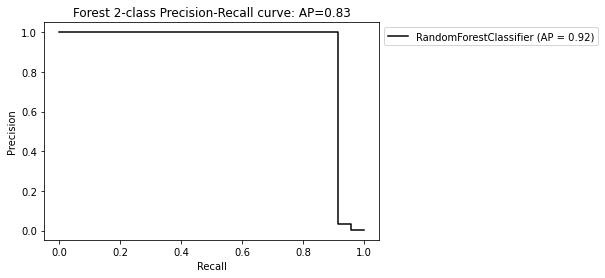

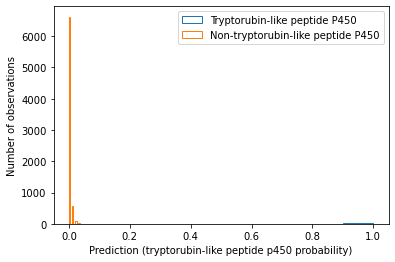

/home/friederike/anaconda3/envs/Diplomarbeit/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/home/friederike/anaconda3/envs/Diplomarbeit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/friederike/anaconda3/envs/Diplomarbeit/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/home/friederike/anaconda3/envs/Diplomarbeit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[2.17115352 1.93900253 2.06017357 1.31818187 1.78895116 2.06017357
 1.25787988 1.75107198 2.06017357 2.06017357 0.69882298 2.38288284
 2.06017357 0.49002632 1.25613722 0.49773914 2.17115352 1.43504857
 2.03368564 0.5092647  1.99100256 1.82500931 0.9129243  2.2077393 ]


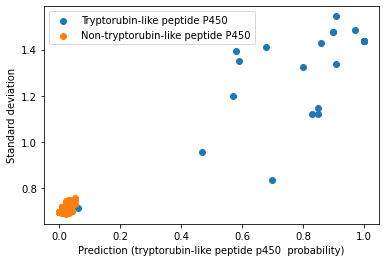

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


ValueError: Found input variables with inconsistent numbers of samples: [7356, 1]

In [13]:
import sklearn
import pandas as pd
import pickle
import forestci as fci
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)

#define max depth of decision tree
maxd=20
foldernameoutput="Output/Tryptorubinlike_peptide"
pathcompletetable=foldernameoutput+"/completetablecomplete.csv"
completetable=pd.read_csv(pathcompletetable)

# define target and features
completetable.drop(columns=['prediction'],inplace=True)
x_data = completetable.loc[:, completetable.columns != 'target' ]
y_data = completetable['target']


# split into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data ,test_size = 0.5, shuffle=True)

#resample to balance 
x_train, y_train = ros.fit_resample(x_train, y_train)

# use decision tree and linear regression classifier for predictions 
forest=RandomForestClassifier(max_depth=maxd,min_samples_leaf=1,class_weight="balanced")
tree= DecisionTreeClassifier(max_depth=maxd,class_weight="balanced",min_samples_leaf=1)

# train classifiers
tree = tree.fit(x_train,y_train)
forest = forest.fit(x_train,y_train)

#predict for test set
test_predict=tree.predict(x_test)
test_predictf=forest.predict(x_test)

#predict for complete set
y_pred = forest.predict(x_data)

completetable['prediction']=y_pred
y_scores = forest.predict_proba(x_test)[:, 1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)

#calculate accuracy
average_precision = average_precision_score(y_test, test_predict)
average_precisionf = average_precision_score(y_test, test_predictf)
baccu=balanced_accuracy_score(y_test, test_predict)
baccuf=balanced_accuracy_score(y_test, test_predictf)
scores = cross_val_score(tree, x_data, y_data, cv=5, scoring='f1_macro')
scoresf = cross_val_score(forest, x_data, y_data, cv=5, scoring='f1_macro')

CM = confusion_matrix(y_test, test_predict)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

CMf = confusion_matrix(y_test, test_predictf)

TNf = CMf[0][0]
FNf = CMf[1][0]
TPf = CMf[1][1]
FPf = CMf[0][1]

#probability of "positive" labeled actually positive:
pt=TP/(TP+FP)

#probability of Tryptorubinlike p450 beeing found
t=TP/(FN+TP)

#probability of "positive" labeled actually positive:
pf=TPf/(TPf+FPf)

#probability of Tryptorubinlike p450 beeing found
tf=TPf/(FNf+TPf)

print("Tree Score:", tree.score(x_test, y_test))
print ("Crossvalidation scores tree:",scores)
print ("Tree:""True negatives:",TN," False Negatives:",FN,"True positives:",TP," False Positives:",FP)
print ("Probability of positive labeled actually positive:", pt)
print ("Probability of Tryptorubinlike p450 beeing found",t)

print("Forest Score:", forest.score(x_test, y_test))
print ("Crossvalidation scores forest:",scoresf)
print ("Forest Balanced Accuracy Score:",baccuf)
print ("forest:""True negatives:",TNf," False Negatives:",FNf,"True positives:",TPf," False Positives:",FPf)
print ("forest probability of positive labeled actually positive:", pf)
print ("forest probability of Tryptorubinlike p450 beeing found",tf)
print('Forest Average precision-recall score: {0:0.2f}'.format(
      average_precisionf))
# plot precision-recall curves
fig, ax = plt.subplots() 
disp = plot_precision_recall_curve(forest, x_test, y_test, ax=ax,color='black')
disp.ax_.set_title('Forest 2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precisionf))
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig(("recisionrecalltryptorubin.png"), format="png")

def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)

    # plot the curve
    plt.figure(figsize=(14,14))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='black', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='black')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');

    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))

# plot precision-recall curves
predict=forest.predict_proba(x_test)
idx_Tryptorubinlike_peptide = np.where(y_test == 1)[0]
idx_nonTryptorubinlike_peptide = np.where(y_test == 0)[0]

# Histogram predictions without error bars:
fig, ax = plt.subplots(1)
ax.hist(predict[idx_Tryptorubinlike_peptide, 1], histtype='step', label='Tryptorubin-like peptide P450')
ax.hist(predict[idx_nonTryptorubinlike_peptide, 1], histtype='step', label='Non-tryptorubin-like peptide P450')
ax.set_xlabel('Prediction (tryptorubin-like peptide p450 probability)')
ax.set_ylabel('Number of observations')
plt.legend()
plt.savefig("histtlp.png",format="png",dpi=1000)
plt.show() 

# Calculate the variance
variance = fci.random_forest_error(forest, x_train, x_test)
fig, ax = plt.subplots(1)
ax.scatter(predict[idx_Tryptorubinlike_peptide, 1],
           np.sqrt(variance[idx_Tryptorubinlike_peptide]),
           label='Tryptorubin-like peptide P450')
ax.scatter(predict[idx_nonTryptorubinlike_peptide, 1],
           np.sqrt(variance[idx_nonTryptorubinlike_peptide]),
           label='Non-tryptorubin-like peptide P450')
ax.set_xlabel('Prediction (tryptorubin-like peptide p450  probability)')
ax.set_ylabel('Standard deviation')
plt.legend()
plt.savefig("variancetlp.png",format="png",dpi=1000)
plt.show()
predict=np.array(predict[:, 1])
precision_rf, recall_rf = precision_recall_curve(y_test.ravel(), [predict])
plt.plot(recall_lr, precision_lr,color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig("recalldiagrtlp.png",format="png",dpi=1000)
plt.show()

#precision_recall_threshold(p, r, thresholds, 0.7)
#save trained classifier
filename = foldernameoutput+'/decisiontreeclassifier.sav'
pickle.dump(tree, open(filename, 'wb'))
filename = foldernameoutput+'/home/friederike/Dokumente/Diplom/Work Friederike/Frankfurt/p450Project/Tryptorubin-like_peptidep450ML/Output/permutationsof4+locus/completetable.csv/forestclassifier.sav'
pickle.dump(forest, open(filename, 'wb'))
pathcompletetable=foldernameoutput+"/completetable.csv"
completetable.to_csv(pathcompletetable, index=False)

# Create a fasta file of all p450, that are false positve

In [6]:
import Bio
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
import pickle 

foldernameoutput="Output/Tryptorubinlike_peptide"
name_450nonTryptorubinlikes='Fasta/all p450.fasta'
pathcompletetable=foldernameoutput+"/completetable.csv"
completetable=pd.read_csv(pathcompletetable)
p450nonTryptorubinlike = completetable.loc[completetable['target'] == 0]
listfalsepositive=[]

# predicts all non Tryptorubinlike p450, if algorithm says "Tryptorubinlike"-> writes to fasta
counter =-1
for seq_record in SeqIO.parse(name_450nonTryptorubinlikes, "fasta"):
    counter= counter+1
    prediction=p450nonTryptorubinlike.iloc[counter,-1] 
    if prediction==1:
        listfalsepositive.append(seq_record)
namelistflasepositive=foldernameoutput+"/listfalsepositive.fasta"
SeqIO.write(listfalsepositive, namelistflasepositive, "fasta")

FileNotFoundError: [Errno 2] No such file or directory: 'Fasta/all p450.fasta'

# Print Decision Tree

In [12]:
import sklearn
import pickle 
from sklearn.tree import export_graphviz
import pydotplus
import pandas as pd
import graphviz

foldernameoutput="Output/Tryptorubinlike_peptide"
filename = foldernameoutput+'/forrestclassifier.sav'
tree = pickle.load(open(filename, 'rb')) 
estimator=tree.estimators_[5]
dot_data = export_graphviz(estimator,
                           feature_names=x_data.columns,
                           out_file=None,
                           filled=True,
                           rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
name_pdf=foldernameoutput+'/tree.pdf'
pydot_graph.write_pdf(name_pdf)

ModuleNotFoundError: No module named 'graphviz'

# Analyse sequences with fragment fastas

In [ ]:
import sklearn
import pandas as pd
import pickle
import Bio
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# enter names of your files here
filenamebegin='Fasta/alignedncbi/allp450ncbiprot-begint-trimmed.fasta'
filenamesbr1='Fasta/alignedncbi/allp450ncbiprot-sbr1t-trimmed.fasta'
filenamesbr2='Fasta/alignedncbi/allp450ncbiprot-sbr2t-trimmed.fasta'
filenamecore='Fasta/alignedncbi/allp450ncbiprot-coret-trimmed.fasta'
filenameend='Fasta/alignedncbi/allp450ncbiprot-endt-trimmed.fasta'
foldernameoutput="Output/Tryptorubinlike_peptide"
filename_permutations=foldernameoutput+"/permutations.txt"
filename = foldernameoutput+'/forestclassifier.sav'
fragments=("begin","sbr1","sbr2","core","end")
filename_index="Output/permutationsof4+locus/newindex.txt"

with open(filename_index, 'r') as f:
    index = [line.rstrip('\n') for line in f]
with open(filename_permutations, 'r') as f:
    permutations = [line.rstrip('\n') for line in f]
def easysequence (sequence):
    #creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr=str(sequence)
    seqlist=list(seqstr)
    a=0
    easylist=[]
    for i in seqlist:
        if i == 'E' or i== 'D':           
            easylist=easylist+['a']
        if i == 'K' or i=='R' or i=='H':      
            easylist=easylist+['b']
        if i == 'S' or i=='T' or i=='N' or i=='Q':
            easylist=easylist+['p']
        if i == 'F' or i=='Y' or i=='W':
            easylist=easylist+['r']
        if i == 'C':
            easylist=easylist+['s']
        if i == 'P':
            easylist=easylist+['t']
        if i == 'G' or i=='A' or i=='V' or i=='L' or i=='I' or i=='M':
            easylist=easylist+['n']
    seperator=''
    easysequence=seperator.join(easylist)
    return easysequence
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z  

#reads file and creates table
tablep450=pd.DataFrame()

#lists for all different files
lbegin=[]
lend=[]
lsbr1=[]
lsbr2=[]
lcore=[]
for seq_record in SeqIO.parse(filenamebegin, "fasta"):
    lbegin.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenamesbr1, "fasta"):
    lsbr1.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenamesbr2, "fasta"):
    lsbr2.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenamecore, "fasta"):
    lcore.append(str(seq_record.seq))
for seq_record in SeqIO.parse(filenameend, "fasta"):
    lend.append(str(seq_record.seq))

for s in range (0,len(lbegin)-1):
    listfragment=[]
    seqbegin=lbegin[s]
    seqsbr1=lsbr1[s]
    seqsbr2=lsbr2[s]
    seqcore=lcore[s]
    seqend=lend[s]
    listfragments=[easysequence(str(seqbegin)),easysequence(str(seqsbr1)),easysequence(str(seqsbr2)),easysequence(str(seqcore)),easysequence(str(seqend))]
    new_row={}
    c=0
    for frag in listfragments:
        f=fragments[c]
        c=c+1
        for i in permutations:
            n=i+f
            new_row =merge_two_dicts(new_row,{n:frag.count(i)})
    tablep450 = tablep450.append(new_row, ignore_index=True)

tablep450n=tablep450.reindex(columns=index)
tablep450n.to_csv("Output/Tryptorubinlike_peptide/tablep450allncbi", index=False) 
listpositive=[]

#SeqIO.write(p450_sequences, filename_outputp450, "fasta")
forest = pickle.load(open(filename, 'rb')) 
predictions = forest.predict_proba(tablep450n)

# predicts all non Tryptorubinlike p450, if algorithm says "Tryptorubinlike"-> writes to fasta
counter =-1
predicitonsfile=pd.DataFrame(columns=['title','probability']   )
for seq_record in SeqIO.parse(filenamebegin, "fasta"):
    counter= counter+1
    prediction=predictions[counter][1]
    row={}
    if prediction>0.5:
        row={'title':seq_record.id,'probability':prediction}
        predicitonsfile = predicitonsfile.append(row, ignore_index=True)
        listpositive.append(seq_record)
namelistpositive=foldernameoutput+"/listpositivetest.fasta"
SeqIO.write(listpositive, namelistpositive, "fasta")
pathcompletetable=foldernameoutput+"/predicitiontabletest.csv"
predicitonsfile.to_csv(pathcompletetable, index=False)    

58119


# Analyse Tree

adapted from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

RandomForestClassifier(class_weight='balanced', max_depth=20)
Feature ranking:
nttpcore 0.039171951607479924
pbbacore 0.03361910248134424
ntnnend 0.03161578688708081
nanpsbr1 0.026053122072174268
trnbcore 0.019034033456644863
tprpcore 0.018232256952108908
tnnaend 0.016191423304965303
nnanend 0.015707965168367404
nannend 0.01528752419158246
brnnsbr2 0.014514814672473356
nnrbsbr2 0.014441357815089602
rpnncore 0.014070110222691265
btabcore 0.013802081675247355
nnracore 0.01359654746057435
bbatcore 0.01322811949106521
nnbncore 0.013037636145589114
bbnnend 0.012901437799194426
nnnnsbr2 0.012173186868602843
bnntcore 0.011822029568558186
prbtsbr1 0.011529598120261579


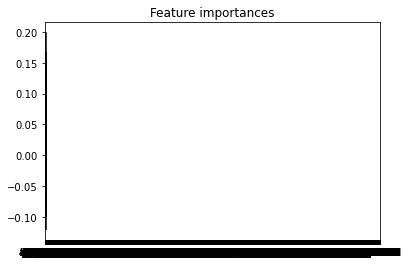

NameError: name 'fig' is not defined

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sklearn

#how many rows?
rows=20
foldernameoutput="Output/Tryptorubinlike_peptide"
filename = foldernameoutput+'/forestclassifier.sav'
filenameout=foldernameoutput+"/importances.txt"
fname=foldernameoutput+"/importances.pdf"
forest = pickle.load(open(filename, 'rb')) 
feature_names=x_data.columns
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,rows):
    print(feature_names[indices[f]],str(importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(rows, importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_data.shape[1]),feature_names)
plt.show()

with open(filenameout, 'w') as file:
    for f in range(0,rows):
        file.write(fea

# Give list of all p450, that contain certain motivs

In [ ]:
# type in the motifs (easycode) that the p450 should contain
yes=()
# type in mptifs, that p450 should not contain
no=()
filename='allp450ncbi.fasta'
foldernameoutput="Output/Tryptorubinlike_peptide"
filenameoutput=foldernameoutput+"/"+str(yes)+".csv"

def easysequence (sequence):
    #creates a string out of the sequence file, that only states if AA is acidic (a), basic (b), polar (p), neutral/unpolar (n),aromatic (r),Cystein (s) or a Prolin (t)
    seqstr=str(sequence)
    seqlist=list(seqstr)
    a=0
    easylist=[]
    for i in seqlist:
        if i == 'E' or i== 'D':
            
            easylist=easylist+['a']
        if i == 'K' or i=='R' or i=='H':
            
            easylist=easylist+['b']
        if i == 'S' or i=='T' or i=='N' or i=='Q':
            
            easylist=easylist+['p']
        if i == 'F' or i=='Y' or i=='W':
            
            easylist=easylist+['r']
        if i == 'C':
            easylist=easylist+['s']
            
        if i == 'P':
            easylist=easylist+['t']
            
        if i == 'G' or i=='A' or i=='V' or i=='L' or i=='I' or i=='M':
            easylist=easylist+['n']
            
    seperator=''
    easysequence=seperator.join(easylist)
    return easysequence
newfile=pd.DataFrame(columns=['info', 'sequence'])
for i in yes:
    newfile[i]=[]
for seq_record in SeqIO.parse(filename, "fasta"):
        new_row={}
        countyes=0
        countno=0
    for i in yes:
        new_row =merge_two_dicts(new_row,{i:easyseq.count(i)})
        countyes=countyes+i:easyseq.count(i)
    for i in no:
        countno=countno+i:easyseq.count(i)
    if countyes>0 and countno==0:
        newfile= newfile.append(new_row, ignore_index=True)

newfile.to_csv(filenameoutput, index=False)